In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import os, json
import re
import json
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd

In [2]:
### SUPPORTING FUNCTIONS
def read_rct_data(dir_name, exp_name):
    '''
    return: dict; key: exp_thr, value: list of rct results
    '''
    # eg: dir_name = 'pg_heavy_results', eg: file_name = 'pgh_thr100_rct.json'
    rct_results = {}
    for file in os.listdir(dir_name):
        if file.endswith('.json'):
            res = []
            match = re.search(r'thr(\d+)_', file)
            exp_thr = match.group(1) 
            with open(os.path.join(dir_name, file), 'r') as f:
                res = json.load(f)
            rct_results[exp_thr] = res
    return (exp_name, rct_results)

def gen_percentile_values(rct_vs_thr_exp_input):
    exp_output = {} # key: exp (eg: pg_heavy), value: dict; key: median/p90/p99 value: {thr: rct value, ...}
    for exp, dets in rct_vs_thr_exp_input:
        exp_output[exp] = {}
        for thr, rct_vals in dets.items():
            # if exp not in exp_output:
            #     exp_output[exp] = {}
            exp_output[exp][thr] = {}
            rct_median = np.median(rct_vals)
            rct_p90 = np.percentile(rct_vals, 90)
            rct_p99 = np.percentile(rct_vals, 99)
            exp_output[exp][thr]['median'] = rct_median
            exp_output[exp][thr]['p90'] = rct_p90
            exp_output[exp][thr]['p99'] = rct_p99
    return exp_output

In [ ]:
# Read ExpWorkloadName from enrichment_config.yaml
ExpWorkloadName = yaml.safe_load(open("enrichment_config.yaml"))["ExpWorkloadName"]
print("ExpWorkloadName:", ExpWorkloadName)

# Analysis Inputs
system_name = "cons_exp_results/pgStrong_mnEventual" # CHANGE FOR NEW SYSTEM
throughput_str = "pgS_mnE_thr2400"
exp_name = "{}/{}".format(system_name, throughput_str)
log_files = glob.glob(f"results/{exp_name}/*.csv")
print(exp_name)

df = pd.concat([pd.read_csv(log_file, names=['tid', 'this_nid', 'logged_time'], usecols=[0, 1, 2]) for log_file in log_files], ignore_index=True)
df['logged_time'] = pd.to_numeric(df['logged_time'], errors='coerce')
# print(df.head())

# Adjust for warmup and cooldown
start_time_of_test = df.loc[df['this_nid'] == 'mewbie_client', 'logged_time'].min()
end_time_of_test = df.loc[df['this_nid'] == 'mewbie_client', 'logged_time'].max()
print("Start time of test:", start_time_of_test)
total_test_time = end_time_of_test - start_time_of_test
lower_cutoff = start_time_of_test + 0.20 * total_test_time
upper_cutoff = start_time_of_test + 0.90 * total_test_time
time_window_seconds = (upper_cutoff - lower_cutoff) / 1000000
print("Time window (seconds):", time_window_seconds)


# Getting valid/completed tids
print("Expworkloadname:", ExpWorkloadName)
tid_logger_nodes = json.load(open(f"enrichment_runs/{ExpWorkloadName}/tid_to_logger_nodes.json"))
invalid_tids_count = 0

def valid_group(group):
    """Returns True if a group contains logs from ALL expected logger nodes for that TID."""
    global invalid_tids_count

    tid = group['tid'].iloc[0]
    expected_logger_nodes = tid_logger_nodes.get(tid)

    # If there are no expected logger nodes, skip
    if not expected_logger_nodes:
        invalid_tids_count += 1
        return False

    actual_logger_nodes = group['this_nid'].values
    if not set(expected_logger_nodes).issubset(actual_logger_nodes):
        invalid_tids_count += 1
        return False

    # Filter once and reuse
    client_times = group.loc[group['this_nid'] == 'mewbie_client', 'logged_time'].values
    if client_times.size == 0:
        invalid_tids_count += 1
        return False

    # Check if any client_time falls within the valid time window
    if ((client_times >= lower_cutoff) & (client_times <= upper_cutoff)).any():
        return True

    invalid_tids_count += 1
    return False


df = df.groupby('tid').filter(valid_group)
num_tids_after_filter = df['tid'].nunique()
print("Number of tids after filtering:", num_tids_after_filter)
print("Number of invalid tids:", invalid_tids_count)

# Completion rate throughput
c_throughput = num_tids_after_filter / time_window_seconds
print("Completion rate throughput:", c_throughput)

rct_results = []
grouped_df = df.groupby('tid')

for tid, group in tqdm(grouped_df, desc="Processing for RCT calc..."):
    max_time = group['logged_time'].max()
    start_time = group.loc[group['this_nid'] == 'mewbie_client', 'logged_time'].min()
    if pd.notna(start_time):
        rct = (max_time - start_time) / 1000
        rct_results.append(rct)

throughput_str = f"{int(c_throughput)}"
new_exp_name = re.sub(r'\d+$', throughput_str, exp_name)
print("New exp_name:", new_exp_name)


with open(f"results/{new_exp_name}_rct_new.json", "w") as f:
    json.dump(rct_results, f)


ExpWorkloadName: cons_exp
cons_exp_results/pgStrong_mnEventual/pgS_mnE_thr1800
Start time of test: 1744550000611743
Time window (seconds): 88.999953
Expworkloadname: cons_exp
Number of tids after filtering: 156757
Number of invalid tids: 70118
Completion rate throughput: 1761.315536874497


Processing for RCT calc...: 100%|██████████| 156757/156757 [01:09<00:00, 2242.67it/s]


New exp_name: cons_exp_results/pgStrong_mnEventual/pgS_mnE_thr1761


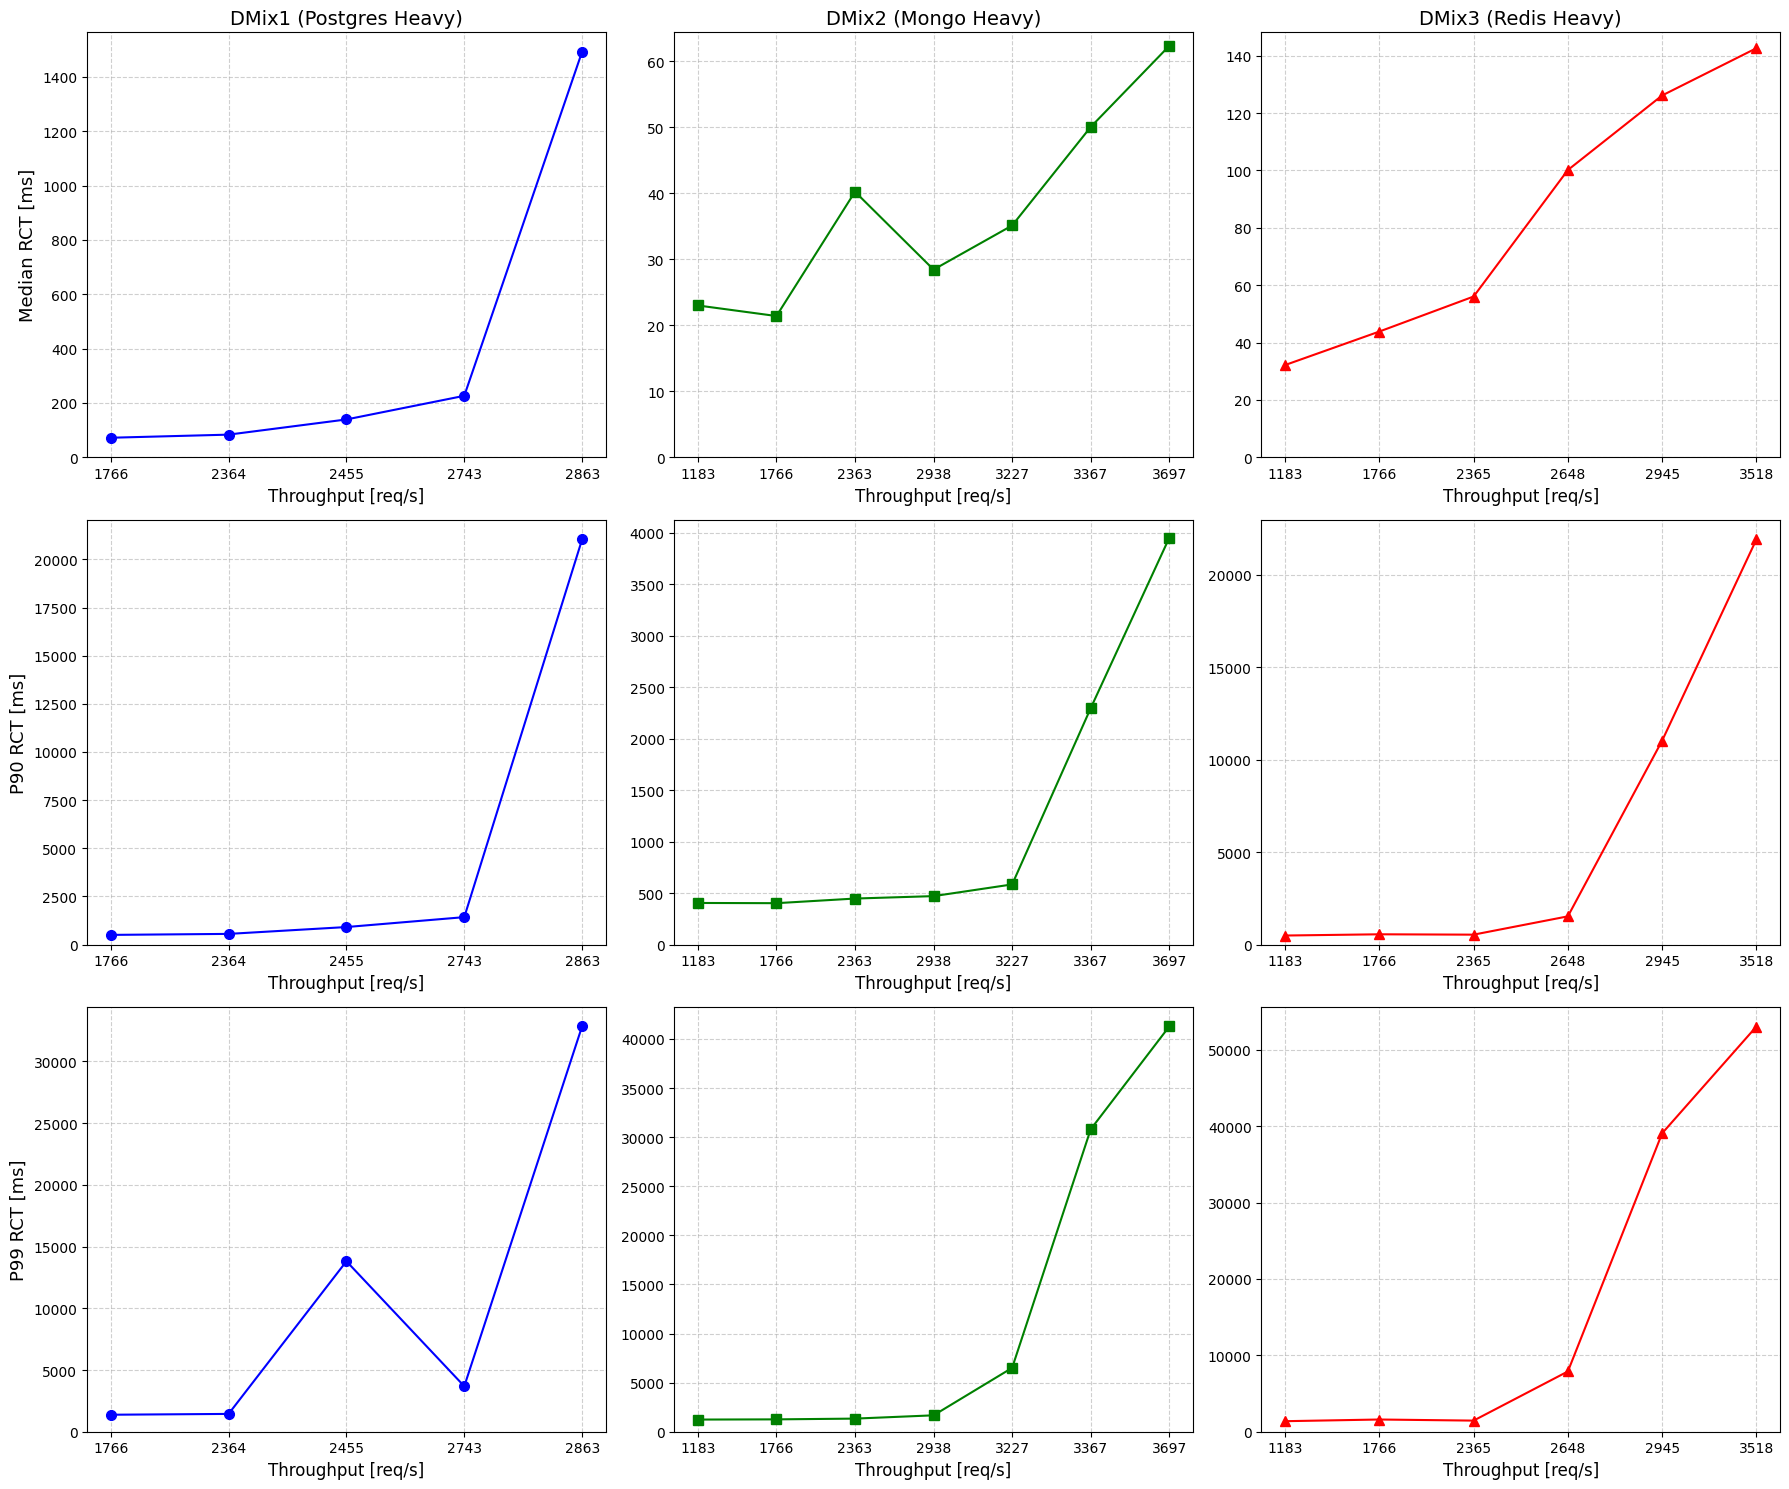

In [135]:
#****************************************************
#### FOR TESTING
#****************************************************

def read_rct_data(dir_name, exp_name):
    '''
    return: dict; key: exp_thr, value: list of rct results
    '''
    # eg: dir_name = 'pg_heavy_results', eg: file_name = 'pgh_thr100_rct.json'
    rct_results = {}
    for file in os.listdir(dir_name):
        if file.endswith('.json'):
            res = []
            match = re.search(r'thr(\d+)_', file)
            exp_thr = match.group(1) 
            with open(os.path.join(dir_name, file), 'r') as f:
                res = json.load(f)
            rct_results[exp_thr] = res
    return (exp_name, rct_results)

pg_rct_res = read_rct_data("./results/dmix_exp_results/pg_heavy_results", "DMix1 (Postgres Heavy)")
mongo_rct_res = read_rct_data("./results/dmix_exp_results/mongo_heavy_results", "DMix2 (Mongo Heavy)")
redis_rct_res = read_rct_data("./results/dmix_exp_results/redis_heavy_results", "DMix3 (Redis Heavy)")
rct_vs_thr_exp_input = [pg_rct_res, mongo_rct_res, redis_rct_res]

def gen_percentile_values(rct_vs_thr_exp_input):
    exp_output = {} # key: exp (eg: pg_heavy), value: dict; key: median/p90/p99 value: {thr: rct value, ...}
    for exp, dets in rct_vs_thr_exp_input:
        exp_output[exp] = {}
        for thr, rct_vals in dets.items():
            # if exp not in exp_output:
            #     exp_output[exp] = {}
            exp_output[exp][thr] = {}
            rct_median = np.median(rct_vals)
            rct_p90 = np.percentile(rct_vals, 90)
            rct_p99 = np.percentile(rct_vals, 99)
            exp_output[exp][thr]['median'] = rct_median
            exp_output[exp][thr]['p90'] = rct_p90
            exp_output[exp][thr]['p99'] = rct_p99
    return exp_output

exp_output = gen_percentile_values(rct_vs_thr_exp_input)

def plot_9_separate_subplots(data, title_suffix="RCT"):
    """
    Plot 9 separate subplots arranged in 3 rows and 3 columns:
    - Rows: Percentiles (Median, P90, P99)
    - Columns: Workloads (Postgres, Mongo, Redis)
    
    Parameters:
    - data (dict): Nested dictionary where each outer key is a workload (e.g., 'Postgres Heavy')
                   and the inner dictionary contains throughput values (keys) and metrics (values).
    - title_suffix (str): Suffix for the titles of the plots.
    """
    percentiles = ['median', 'p90', 'p99']  
    workloads = list(data.keys())  
    colors = ['b', 'g', 'r']  # Colors for lines
    markers = ['o', 's', '^']  # Markers for lines
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # 3 rows, 3 columns
    
    for row_idx, percentile in enumerate(percentiles):
        for col_idx, workload in enumerate(workloads):
            ax = axes[row_idx, col_idx]
            workload_data = data[workload]
            x = sorted(workload_data.keys(), key=lambda k: int(k))  # Sort throughput keys
            y = [workload_data[thr][percentile] for thr in x]  # Extract RCT values
            
            # Plot data
            ax.plot(
                x, y,
                color=colors[col_idx % len(colors)],
                marker=markers[col_idx % len(markers)],
                markersize=7,
                label=f'{percentile.capitalize()}'
            )
            
            # Set labels, titles, and grid
            if row_idx == 0:
                ax.set_title(f'{workload}', fontsize=14)
            if col_idx == 0:
                ax.set_ylabel(f'{percentile.capitalize()} RCT [ms]', fontsize=13)
            ax.set_xlabel('Throughput [req/s]', fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_yscale('linear')
            ax.set_ylim(0)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_9_separate_subplots(exp_output)

### Throughput vs RCT Analysis

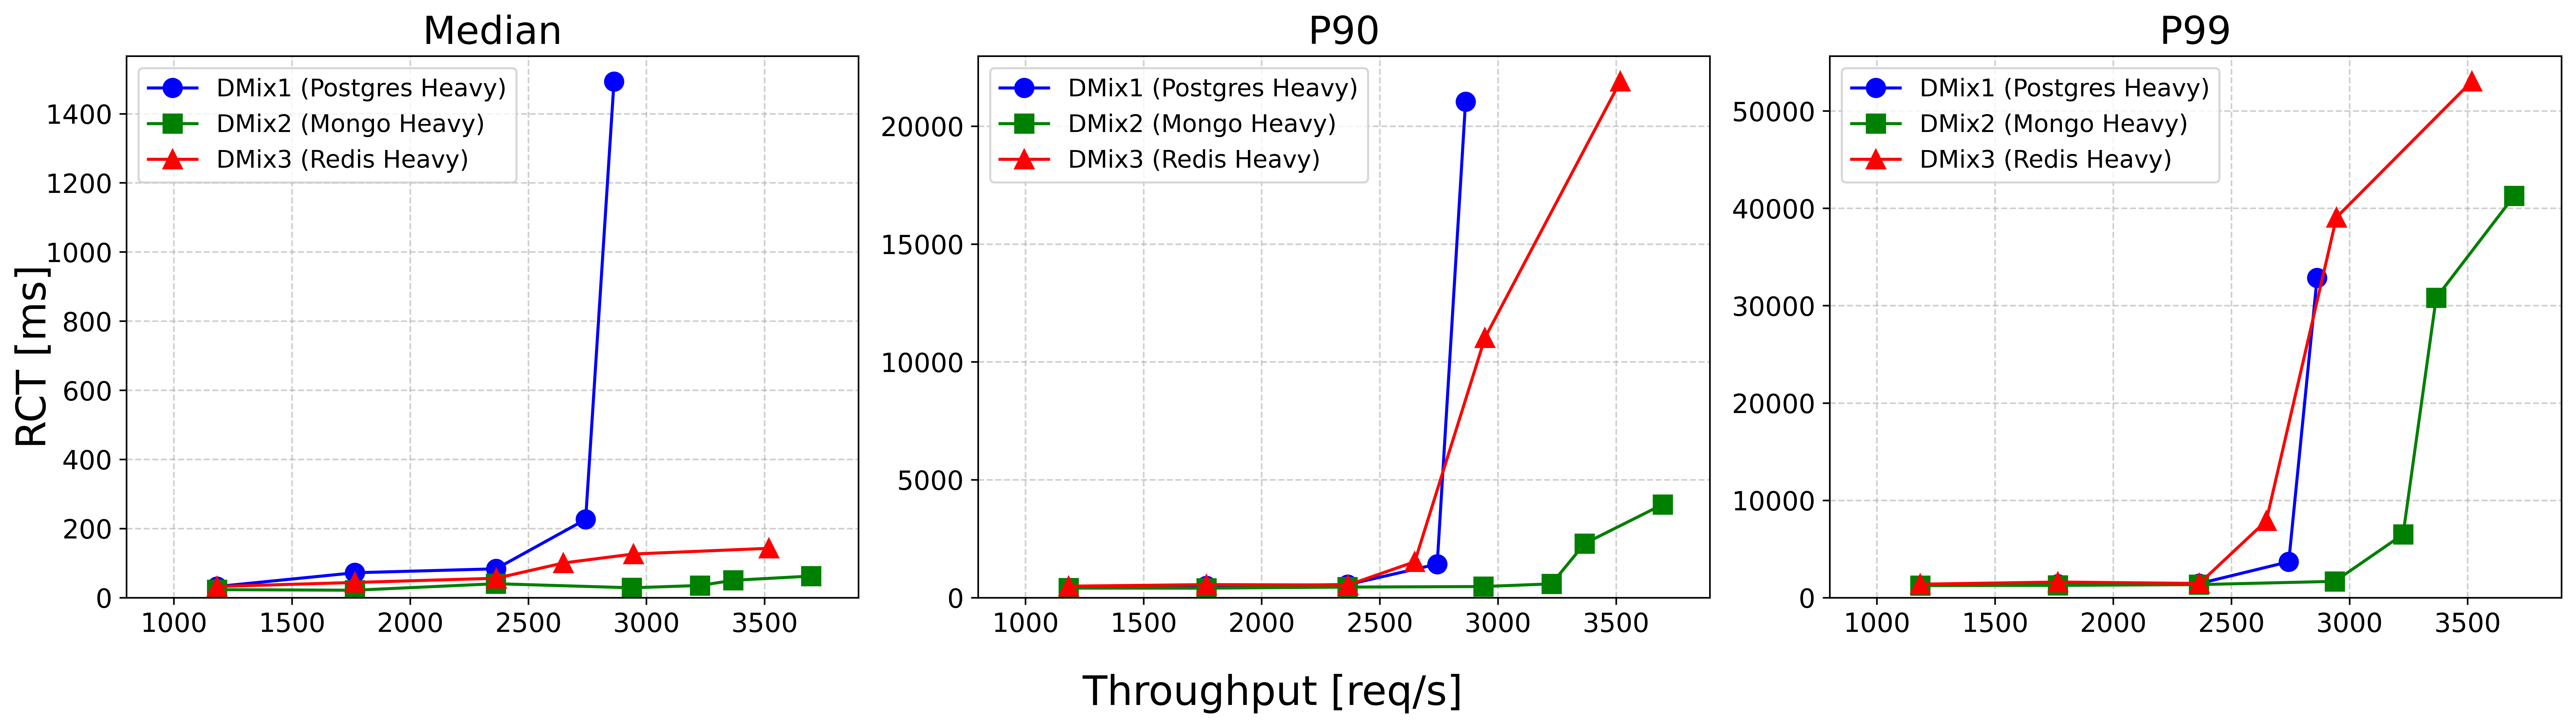

In [10]:
def read_rct_data(dir_name, exp_name):
    '''
    return: dict; key: exp_thr, value: list of rct results
    '''
    # eg: dir_name = 'pg_heavy_results', eg: file_name = 'pgh_thr100_rct.json'
    rct_results = {}
    for file in os.listdir(dir_name):
        if file.endswith('.json'):
            res = []
            match = re.search(r'thr(\d+)_', file)
            exp_thr = match.group(1) 
            with open(os.path.join(dir_name, file), 'r') as f:
                res = json.load(f)
            rct_results[exp_thr] = res
    return (exp_name, rct_results)

pg_rct_res = read_rct_data("./results/dmix_exp_results/pg_heavy_results", "DMix1 (Postgres Heavy)")
mongo_rct_res = read_rct_data("./results/dmix_exp_results/mongo_heavy_results", "DMix2 (Mongo Heavy)")
redis_rct_res = read_rct_data("./results/dmix_exp_results/redis_heavy_results", "DMix3 (Redis Heavy)")
rct_vs_thr_exp_input = [pg_rct_res, mongo_rct_res, redis_rct_res]

def gen_percentile_values(rct_vs_thr_exp_input):
    exp_output = {} # key: exp (eg: pg_heavy), value: dict; key: median/p90/p99 value: {thr: rct value, ...}
    for exp, dets in rct_vs_thr_exp_input:
        exp_output[exp] = {}
        for thr, rct_vals in dets.items():
            # if exp not in exp_output:
            #     exp_output[exp] = {}
            exp_output[exp][thr] = {}
            rct_median = np.median(rct_vals)
            rct_p90 = np.percentile(rct_vals, 90)
            rct_p99 = np.percentile(rct_vals, 99)
            exp_output[exp][thr]['median'] = rct_median
            exp_output[exp][thr]['p90'] = rct_p90
            exp_output[exp][thr]['p99'] = rct_p99
    return exp_output

exp_output = gen_percentile_values(rct_vs_thr_exp_input)
def plot_3_combined_graphs(data, title_suffix="RCT"):
    """
    Plot 3 separate graphs (one for each percentile: median, p90, p99).
    Each graph contains multiple workloads as separate lines.

    Parameters:
    - data (dict): Nested dictionary where each outer key is a workload (e.g., 'Postgres Heavy')
                   and the inner dictionary contains throughput values (keys) and metrics (values).
    - title_suffix (str): Suffix for the titles of the plots.
    """
    percentiles = ['median', 'p90', 'p99']
    workloads = list(data.keys())
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Unique colors for different workloads
    markers = ['o', 's', '^', 'D', 'x', 'P', '*']  # Unique markers for workloads

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns for three graphs

    for idx, percentile in enumerate(percentiles):
        ax = axes[idx]

        # Find the overall x-axis range across all workloads
        all_x_values = sorted({int(k) for workload in workloads for k in data[workload].keys()})
        x_min, x_max = min(all_x_values), max(all_x_values)

        for i, workload in enumerate(workloads):
            workload_data = data[workload]

            # Convert throughput keys to integers and sort
            x = sorted([int(k) for k in workload_data.keys()])
            y = [workload_data[str(thr)][percentile] for thr in x]  # Extract RCT values

            # Plot each workload on the same graph
            ax.plot(
                x, y,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                markersize=9,
                label=f'{workload}'
            )

        # Set labels, titles, and grid
        ax.set_title(f'{percentile.capitalize()}', fontsize=19)
        # ax.set_xlabel('Throughput [req/s]', fontsize=19, labelpad=10)
        # ax.set_ylabel('RCT [ms]', fontsize=19, labelpad=5)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_yscale('linear')
        ax.set_ylim(0)
        # x-asis fontsize=12
        # y-axis fontsize=13
        # ax.tick_params(axis='x', labelsize=12)
        # ax.tick_params(axis='y', labelsize=13)
    
        # if percentile == 'p90':
        #     ax.set_ylim(0, 7300)  # *** Fixed max y-axis for p90 ***
        # else:
        #     ax.set_ylim(0)
        # if percentile == 'p99':
        #     ax.set_ylim(0, 14600)  # *** Fixed max y-axis for p90 ***
        # else:
        #     ax.set_ylim(0)

        # Set x-axis ticks at rounded intervals
        tick_interval = 500  # Adjust if needed
        # ax.set_xticks(np.arange(0, x_max + tick_interval, tick_interval))
        ax.set_xticks(np.concatenate(([0], np.arange(1000, x_max + 500, 500))))
        ax.set_xlim(800,x_max+200)

        # Add legend
        ax.legend(fontsize=12)
    fig.supxlabel('Throughput [req/s]', fontsize=20)
    fig.supylabel('RCT [ms]', fontsize=20)

    # Adjust layout
    plt.tight_layout()
    plt.show()


plot_3_combined_graphs(exp_output)


## Consistency Runs

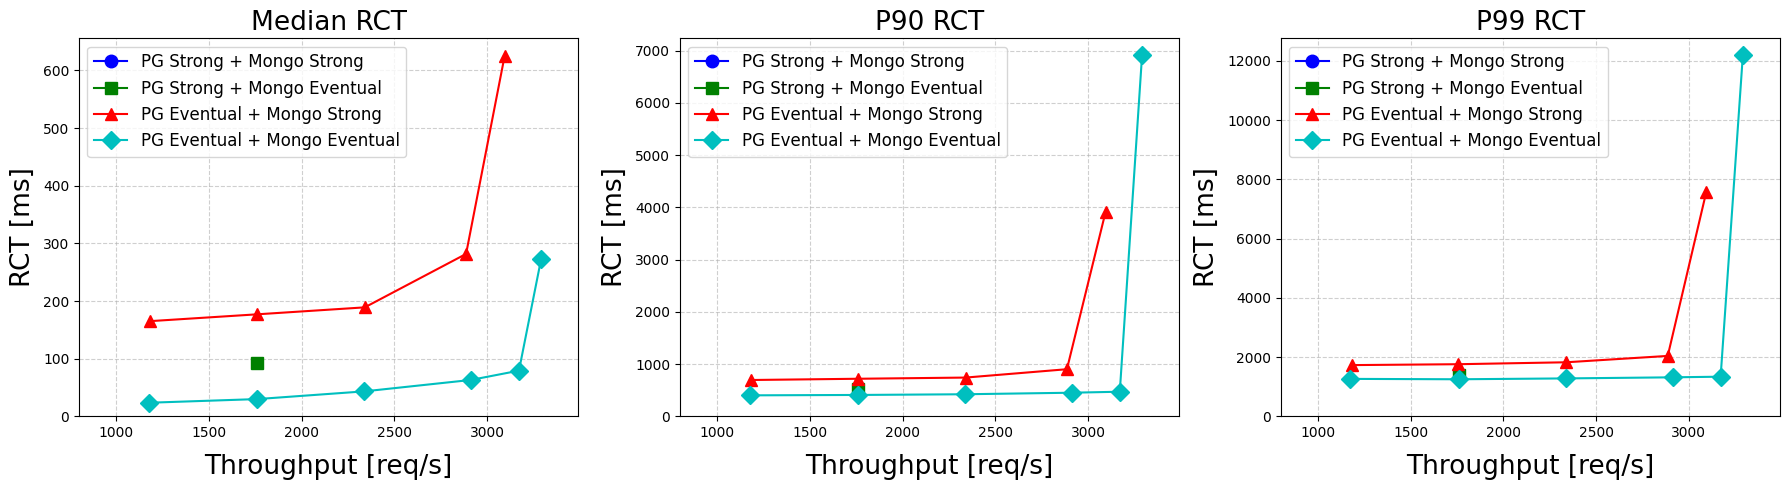

In [4]:

pgs_mns_res = read_rct_data("./results/cons_exp_results/pgStrong_mnStrong", "PG Strong + Mongo Strong")
pgs_mne_res = read_rct_data("./results/cons_exp_results/pgStrong_mnEventual", "PG Strong + Mongo Eventual")
pge_mns_res = read_rct_data("./results/cons_exp_results/pgEventual_mnStrong", "PG Eventual + Mongo Strong")
pge_mne_res = read_rct_data("./results/cons_exp_results/pgEventual_mnEventual", "PG Eventual + Mongo Eventual")
cons_exp_input = [pgs_mns_res, pgs_mne_res, pge_mns_res, pge_mne_res]

exp_output = gen_percentile_values(cons_exp_input)
def plot_3_combined_graphs(data, title_suffix="RCT"):
    """
    Plot 3 separate graphs (one for each percentile: median, p90, p99).
    Each graph contains multiple workloads as separate lines.

    Parameters:
    - data (dict): Nested dictionary where each outer key is a workload (e.g., 'Postgres Heavy')
                   and the inner dictionary contains throughput values (keys) and metrics (values).
    - title_suffix (str): Suffix for the titles of the plots.
    """
    percentiles = ['median', 'p90', 'p99']
    workloads = list(data.keys())
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Unique colors for different workloads
    markers = ['o', 's', '^', 'D', 'x', 'P', '*']  # Unique markers for workloads

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns for three graphs

    for idx, percentile in enumerate(percentiles):
        ax = axes[idx]

        # Find the overall x-axis range across all workloads
        all_x_values = sorted({int(k) for workload in workloads for k in data[workload].keys()})
        x_min, x_max = min(all_x_values), max(all_x_values)

        for i, workload in enumerate(workloads):
            workload_data = data[workload]

            # Convert throughput keys to integers and sort
            x = sorted([int(k) for k in workload_data.keys()])
            y = [workload_data[str(thr)][percentile] for thr in x]  # Extract RCT values

            # Plot each workload on the same graph
            ax.plot(
                x, y,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                markersize=9,
                label=f'{workload}'
            )

        # Set labels, titles, and grid
        ax.set_title(f'{percentile.capitalize()} RCT', fontsize=19)
        ax.set_xlabel('Throughput [req/s]', fontsize=19, labelpad=10)
        ax.set_ylabel('RCT [ms]', fontsize=19, labelpad=5)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_yscale('linear')
        ax.set_ylim(0)
        # x-asis fontsize=12
        # y-axis fontsize=13
        # ax.tick_params(axis='x', labelsize=12)
        # ax.tick_params(axis='y', labelsize=13)
    
        # if percentile == 'p90':
        #     ax.set_ylim(0, 7300)  # *** Fixed max y-axis for p90 ***
        # else:
        #     ax.set_ylim(0)
        # if percentile == 'p99':
        #     ax.set_ylim(0, 14600)  # *** Fixed max y-axis for p90 ***
        # else:
        #     ax.set_ylim(0)

        # Set x-axis ticks at rounded intervals
        tick_interval = 500  # Adjust if needed
        # ax.set_xticks(np.arange(0, x_max + tick_interval, tick_interval))
        ax.set_xticks(np.concatenate(([0], np.arange(1000, x_max + 500, 500))))
        ax.set_xlim(800,x_max+200)

        # Add legend
        ax.legend(fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_3_combined_graphs(exp_output)

## Latency Decomposition Analysis

In [13]:

# Load workload name
ExpWorkloadName = yaml.safe_load(open("enrichment_config.yaml"))["ExpWorkloadName"]

# Config and data load
system_name = "cons_exp_results/pgEventual_mnStrong"
throughput_str = "pgE_mnS_thr3000"
exp_name = f"{system_name}/{throughput_str}"
log_files = glob.glob(f"results/{exp_name}/*.csv")

# Read log data with conditional schema
log_dfs = []
for log_file in log_files:
    if "client_log.csv" in log_file:
        df_part = pd.read_csv(log_file, names=['tid', 'this_nid', 'logged_time'], usecols=[0, 1, 2])
    else:
        df_part = pd.read_csv(
            log_file,
            names=['tid', 'this_nid', 'logged_time', 'log_type', 'db_type', 'db_node', 'latency'],
            usecols=[0, 1, 2, 3, 4, 5, 6]
        )
    log_dfs.append(df_part)

df = pd.concat(log_dfs, ignore_index=True)
df['logged_time'] = pd.to_numeric(df['logged_time'], errors='coerce')

# Time window cutoffs
start_time_of_test = df.loc[df['this_nid'] == 'mewbie_client', 'logged_time'].min()
end_time_of_test = df.loc[df['this_nid'] == 'mewbie_client', 'logged_time'].max()
total_test_time = end_time_of_test - start_time_of_test
lower_cutoff = start_time_of_test + 0.20 * total_test_time
upper_cutoff = start_time_of_test + 0.90 * total_test_time
time_window_seconds = (upper_cutoff - lower_cutoff) / 1_000_000

# Load valid TID logger node mapping
tid_logger_nodes = json.load(open(f"enrichment_runs/{ExpWorkloadName}/tid_to_logger_nodes.json"))
invalid_tids_count = 0

def valid_group(group):
    global invalid_tids_count
    tid = group['tid'].iloc[0]
    expected_logger_nodes = tid_logger_nodes.get(tid)
    if not expected_logger_nodes:
        invalid_tids_count += 1
        return False
    actual_logger_nodes = group['this_nid'].values
    if not set(expected_logger_nodes).issubset(actual_logger_nodes):
        invalid_tids_count += 1
        return False
    client_times = group.loc[group['this_nid'] == 'mewbie_client', 'logged_time'].values
    if client_times.size == 0:
        invalid_tids_count += 1
        return False
    if ((client_times >= lower_cutoff) & (client_times <= upper_cutoff)).any():
        return True
    invalid_tids_count += 1
    return False

df = df.groupby('tid').filter(valid_group)
grouped_df = df.groupby('tid')
print("Valid groups extracted:", len(grouped_df))

# Define allowed DB nodes
allowed_db_nodes = {"n4576", "n103", "n1082", "n744", "n9555", "n3184", "n4835", "n750"}

# Extract RCT and DB time
db_breakdown = []
for tid, group in tqdm(grouped_df, desc="Computing DB time contributions"):
    client_times = group.loc[group['this_nid'] == 'mewbie_client', 'logged_time']
    if client_times.empty:
        continue
    start_time = client_times.min()
    end_time = group['logged_time'].max()
    rct_us = end_time - start_time
    rct_ms = rct_us / 1000

    # Extract DB latencies for allowed nodes
    if 'log_type' in group.columns and 'latency' in group.columns and 'db_node' in group.columns:
        sync_logs = group[(group['log_type'] == 'Sync') & (group['db_node'].isin(allowed_db_nodes))]
        sync_logs = sync_logs.dropna(subset=['latency'])

        def parse_latency(lat_str):
            try:
                if lat_str.endswith('ms'):
                    return float(lat_str.replace('ms', ''))
                elif lat_str.endswith('µs'):
                    return float(lat_str.replace('µs', '')) / 1000
            except:
                return 0.0
            return 0.0

        sync_logs['latency_ms'] = sync_logs['latency'].apply(parse_latency)

        if not sync_logs.empty:
            db_times_by_node = sync_logs.groupby('db_node')['latency_ms'].sum()
            db_time_ms = db_times_by_node.max()  # Highest total time among allowed nodes
        else:
            db_time_ms = 0.0
    else:
        db_time_ms = 0.0

    if rct_ms > 0:
        db_time_pct = (db_time_ms / rct_ms) * 100
    else:
        db_time_pct = 0.0

    db_breakdown.append({
        "tid": tid,
        "rct_ms": round(rct_ms, 3),
        "db_time_ms": round(db_time_ms, 3),
        "db_time_pct": round(db_time_pct, 2)
    })

    # Debug print for first entry only
    # print(db_breakdown[0])
    # break  # remove this line if you want full processing

# Output file name (
output_file = f"results/cons_exp_results/{throughput_str}_rct_db_breakdown.json"
print("Output file:", output_file)

with open(output_file, "w") as f:
    json.dump(db_breakdown, f, indent=2)


Valid groups extracted: 157186


Computing DB time contributions: 100%|██████████| 157186/157186 [06:55<00:00, 378.49it/s]


Output file: results/cons_exp_results/pgE_mnS_thr3000_rct_db_breakdown.json


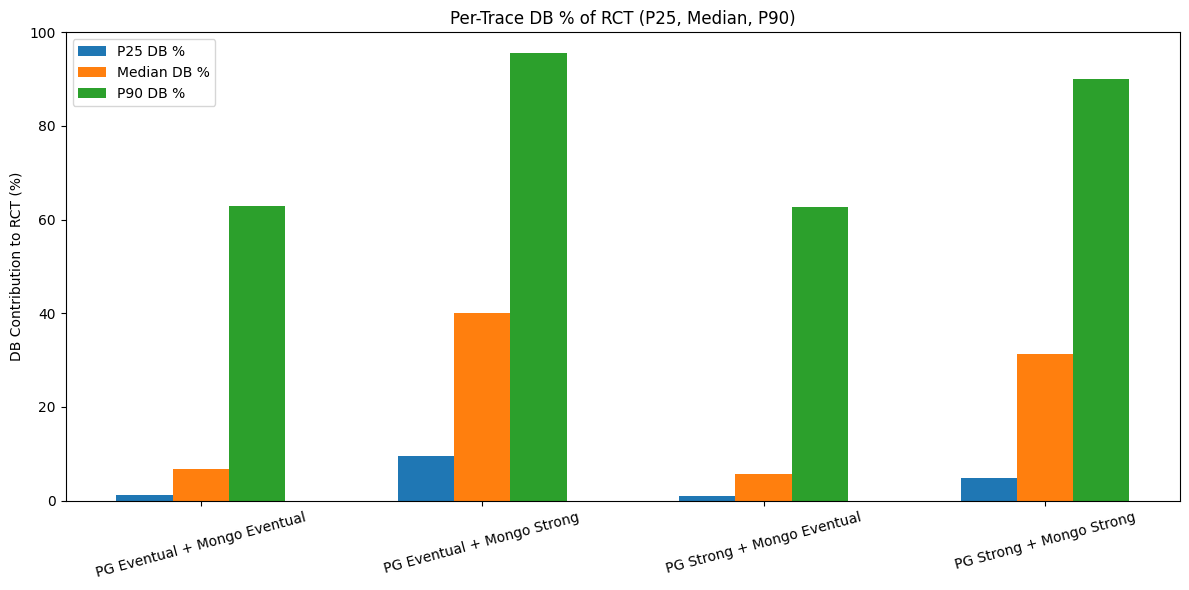

In [20]:

# Helper: convert filename to system label
def parse_system_label(filename: str) -> str:
    parts = filename.split("_")
    pg_mode = parts[0][-1]  # 'S' or 'E'
    mn_mode = parts[1][-1]  # 'S' or 'E'
    pg_label = "PG Strong" if pg_mode == 'S' else "PG Eventual"
    mn_label = "Mongo Strong" if mn_mode == 'S' else "Mongo Eventual"
    return f"{pg_label} + {mn_label}"

# Input directory with *_rct_db_breakdown.json files
input_dir = "results/cons_exp_results"  # ← Change if needed

records = []

for filename in os.listdir(input_dir):
    if not filename.endswith("_rct_db_breakdown.json"):
        continue

    filepath = os.path.join(input_dir, filename)
    system_label = parse_system_label(filename)

    with open(filepath) as f:
        traces = json.load(f)

    db_pcts = []
    for trace in traces:
        rct = trace.get("rct_ms", 0)
        db_time = trace.get("db_time_ms", 0)
        if rct > 0:
            db_pct = (db_time / rct) * 100
            db_pcts.append(db_pct)

    if db_pcts:
        s = pd.Series(db_pcts)
        records.extend([
            {"system": system_label, "stat": "P25", "db_pct": s.quantile(0.25)},
            {"system": system_label, "stat": "Median", "db_pct": s.median()},
            {"system": system_label, "stat": "P90", "db_pct": s.quantile(0.90)},
        ])

# Convert to DataFrame
df = pd.DataFrame(records)

# Ordered systems for consistent display
systems = sorted(df["system"].unique())
stats = ["P25", "Median", "P90"]
x = range(len(systems))
bar_width = 0.2

# Plot grouped bars
plt.figure(figsize=(12, 6))
for i, stat in enumerate(stats):
    stat_vals = df[df["stat"] == stat].set_index("system").loc[systems]["db_pct"]
    positions = [pos + i * bar_width for pos in x]
    plt.bar(positions, stat_vals, width=bar_width, label=f"{stat} DB %")

plt.xticks([pos + bar_width for pos in x], systems, rotation=15)
plt.ylabel("DB Contribution to RCT (%)")
plt.title("Per-Trace DB % of RCT (P25, Median, P90)")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()
